**Importing the data from Kaggle**

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d drgilermo/face-images-with-marked-landmark-points

100% 105M/105M [00:05<00:00, 23.8MB/s]
100% 105M/105M [00:05<00:00, 18.5MB/s]


In [3]:
!unzip face-images-with-marked-landmark-points.zip

Archive:  face-images-with-marked-landmark-points.zip
  inflating: face_images.npz         
  inflating: facial_keypoints.csv    


**Importing Dependencies**

In [4]:
import numpy as np
import pandas as pd
import keras
import cv2 as cv
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Dense, Dropout, Input
from keras.models import Sequential, Model
from sklearn.metrics import mean_absolute_error

**Loading the images**

In [5]:
images = np.load('/content/face_images.npz')
faces = images.get(images.files[0])
faces=np.moveaxis(faces,-1,0)
faces=faces.reshape(faces.shape[0],faces.shape[1],faces.shape[1],1)

In [6]:
print(f"shape of the faces {faces.shape}")

shape of the faces (7049, 96, 96, 1)


In [7]:
df = pd.read_csv('/content/facial_keypoints.csv')

In [8]:
df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


In [9]:
df.corr()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
left_eye_center_x,1.000000,0.029908,0.274459,-0.154728,0.856572,0.022211,0.879976,0.062128,0.308649,-0.104698,...,0.457468,0.192274,0.422891,0.284087,-0.008382,0.202842,0.260753,0.151302,0.374314,0.265655
left_eye_center_y,0.029908,1.000000,0.259012,0.346331,0.065749,0.926728,-0.013411,0.956066,0.101996,0.537101,...,-0.166891,0.333053,-0.340755,0.480924,-0.392434,0.219366,-0.425576,0.251472,-0.379980,0.130062
right_eye_center_x,0.274459,0.259012,1.000000,0.067621,0.294550,0.127367,-0.024408,0.060942,0.817895,0.090214,...,0.402189,0.024502,0.061124,-0.172144,0.424439,-0.215123,0.308889,-0.109026,0.319541,-0.251105
right_eye_center_y,-0.154728,0.346331,0.067621,1.000000,-0.149295,0.531960,-0.144389,0.221829,0.055758,0.923050,...,0.182866,0.329233,0.312434,0.098019,0.257956,0.397645,0.294145,0.198499,0.344010,0.044597
left_eye_inner_corner_x,0.856572,0.065749,0.294550,-0.149295,1.000000,-0.021444,0.653318,0.080430,0.267661,-0.172852,...,0.387317,-0.054712,0.287427,0.156495,0.145968,0.046439,0.322217,-0.083635,0.242669,0.303769
left_eye_inner_corner_y,0.022211,0.926728,0.127367,0.531960,-0.021444,1.000000,0.010531,0.869743,0.150281,0.710354,...,-0.091006,0.426897,-0.211855,0.493657,-0.335989,0.327081,-0.315929,0.387311,-0.367069,0.308555
left_eye_outer_corner_x,0.879976,-0.013411,-0.024408,-0.144389,0.653318,0.010531,1.000000,0.054156,0.316254,-0.094245,...,0.179189,0.165361,0.507755,0.325291,-0.136411,0.263466,0.229154,0.292129,0.176392,0.332880
left_eye_outer_corner_y,0.062128,0.956066,0.060942,0.221829,0.080430,0.869743,0.054156,1.000000,0.050529,0.373183,...,-0.176047,0.222928,-0.392594,0.506364,-0.462165,0.183239,-0.494482,0.216060,-0.561581,0.329316
right_eye_inner_corner_x,0.308649,0.101996,0.817895,0.055758,0.267661,0.150281,0.316254,0.050529,1.000000,0.124023,...,0.377931,0.118548,0.262597,-0.054888,0.262056,-0.094748,0.369890,0.109785,0.309453,-0.230177
right_eye_inner_corner_y,-0.104698,0.537101,0.090214,0.923050,-0.172852,0.710354,-0.094245,0.373183,0.124023,1.000000,...,0.053212,0.356647,0.237858,0.225398,0.108121,0.449346,0.176403,0.354693,0.203002,0.164086


In [10]:
df.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [11]:
def missing_values(df, column):    # handling the missing values with mean 
  df[column] = df[column].fillna(df[column].mean())

In [12]:
for i in df.columns:
  missing_values(df, i)

In [13]:
df.isnull().sum()

left_eye_center_x            0
left_eye_center_y            0
right_eye_center_x           0
right_eye_center_y           0
left_eye_inner_corner_x      0
left_eye_inner_corner_y      0
left_eye_outer_corner_x      0
left_eye_outer_corner_y      0
right_eye_inner_corner_x     0
right_eye_inner_corner_y     0
right_eye_outer_corner_x     0
right_eye_outer_corner_y     0
left_eyebrow_inner_end_x     0
left_eyebrow_inner_end_y     0
left_eyebrow_outer_end_x     0
left_eyebrow_outer_end_y     0
right_eyebrow_inner_end_x    0
right_eyebrow_inner_end_y    0
right_eyebrow_outer_end_x    0
right_eyebrow_outer_end_y    0
nose_tip_x                   0
nose_tip_y                   0
mouth_left_corner_x          0
mouth_left_corner_y          0
mouth_right_corner_x         0
mouth_right_corner_y         0
mouth_center_top_lip_x       0
mouth_center_top_lip_y       0
mouth_center_bottom_lip_x    0
mouth_center_bottom_lip_y    0
dtype: int64

In [14]:
face_points = []     # appending the landmarks into face_points list
for i in range(df.shape[0]):
  face_points.append(list(df.iloc[i,:]))

In [15]:
face_points = np.array(face_points)    #converting the face points into numpy array

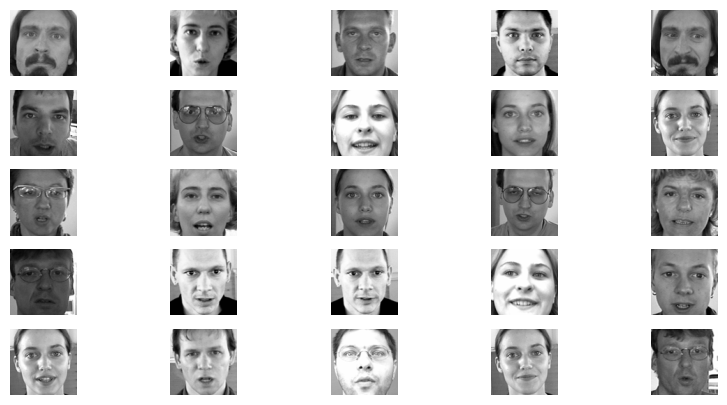

In [16]:
plt.figure(figsize=(10,5))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(faces[i], cmap='gray')
  plt.axis("off")
plt.show()

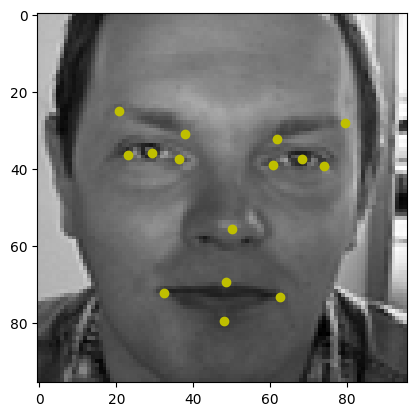

In [17]:
def plot_points(img_number):
  points = list(df.iloc[img_number,:])
  plt.imshow(faces[img_number], cmap='gray')
  for i in range(0, len(points), 2):
    plt.scatter(points[i:i+2][0], points[i:i+2][1], c='y')
  plt.show()
plot_points(799)

In [18]:
faces = faces/255      # normalising the faces

In [19]:
x_train, x_test, y_train, y_test = train_test_split(faces, face_points, test_size = 0.2, random_state=44)

In [20]:
print(f"the shape of x_train is {x_train.shape}")
print(f"the shape of y_train is {y_train.shape}")
print(f"the shape of x_test is {x_test.shape}")
print(f"the shape of y_test is {y_test.shape}")

the shape of x_train is (5639, 96, 96, 1)
the shape of y_train is (5639, 30)
the shape of x_test is (1410, 96, 96, 1)
the shape of y_test is (1410, 30)


**CNN Model**

In [21]:
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape=(96,96,1), activation="relu", padding="same"))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.1))
model.add(Conv2D(64, (3,3), activation="relu",padding="same"))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3,3), activation="relu", padding="same"))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))
model.add(Conv2D(256, (3,3), activation="relu", padding="same"))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation="relu"))
model.add(Dense(30, activation="leaky_relu"))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0

In [23]:
model.compile(optimizer="adam", loss="mse", metrics=['mae'])

In [24]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Epoch 1/100
177/177 [==============================] - 15s 25ms/step - loss: 247.6686 - mae: 8.0113 - val_loss: 83.7798 - val_mae: 8.1261
Epoch 2/100
177/177 [==============================] - 3s 17ms/step - loss: 10.6864 - mae: 2.1842 - val_loss: 113.7821 - val_mae: 9.6577
Epoch 3/100
177/177 [==============================] - 3s 16ms/step - loss: 9.2263 - mae: 1.9392 - val_loss: 110.1818 - val_mae: 9.4742
Epoch 4/100
177/177 [==============================] - 3s 16ms/step - loss: 9.3054 - mae: 1.9498 - val_loss: 98.8887 - val_mae: 8.9893
Epoch 5/100
177/177 [==============================] - 3s 16ms/step - loss: 9.6848 - mae: 2.0189 - val_loss: 103.1080 - val_mae: 9.1244
Epoch 6/100
177/177 [==============================] - 3s 16ms/step - loss: 8.8998 - mae: 1.8674 - val_loss: 159.7516 - val_mae: 11.5458
Epoch 7/100
177/177 [==============================] - 3s 17ms/step - loss: 9.4427 - mae: 1.9738 - val_loss: 111.6284 - val_mae: 9.5531
Epoch 8/100
177/177 [========================

In [25]:
y_pred = model.predict(x_test)

45/45 [==============================] - 0s 4ms/step


In [26]:
print(f"mean absolute error of the model is {mean_absolute_error(y_pred, y_test)}")

mean absolute error of the model is 2.606207433861229


1/1 [==============================] - 0s 139ms/step


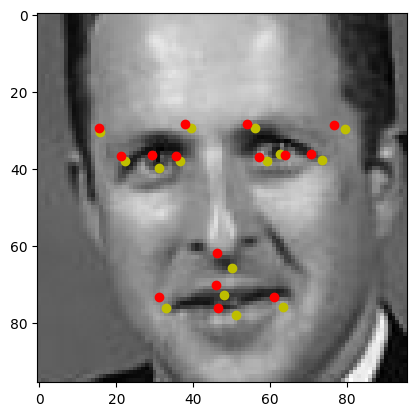

In [27]:
def plot_points(img_number):
  plt.imshow(x_test[img_number], cmap='gray')
  predicted_points = model.predict(x_test[img_number].reshape(1, 96, 96, 1))
  predicted_points = predicted_points[0]
  original_points = y_test[img_number]
  for i in range(0, 30, 2):
    plt.scatter(original_points[i:i+2][0], original_points[i:i+2][1], c='y')     #original
    plt.scatter(predicted_points[i:i+2][0], predicted_points[i:i+2][1], c='r')   #predicted 
  plt.show()
plot_points(555)

**CNN Model as Feature Extractor + Random Forest for Regression**

In [29]:
features_model = Model(inputs = [model.input], outputs = [model.get_layer("global_average_pooling2d").output]) 
#creating a model with above CNN model upto GlobalAveragePooling2D layer output

In [30]:
train_features = features_model.predict(x_train)   # predicting the features on x_train

177/177 [==============================] - 1s 3ms/step


In [31]:
rf_reg = RandomForestRegressor()

In [32]:
rf_reg.fit(train_features, y_train)  # fitting random forest on train_features and y_train

RandomForestRegressor()

In [33]:
test_features = features_model.predict(x_test)  # predicting the test features

45/45 [==============================] - 0s 3ms/step


In [34]:
output_points = rf_reg.predict(test_features)   # predicting the output features

In [35]:
print(f"the mean abosulute error for random forest regressor is {mean_absolute_error(output_points, y_test)}")

the mean abosulute error for random forest regressor is 1.2129046985875478


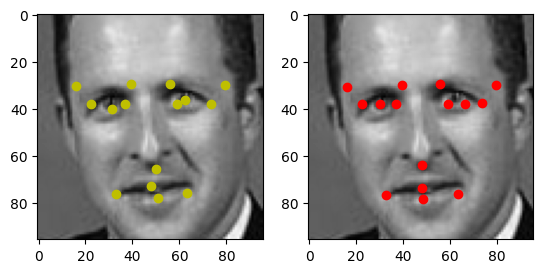

In [36]:
def plot_output(img_number):
  predicted_points = output_points[img_number]
  original_points = y_test[img_number]
  plt.subplot(1,2,1)
  plt.imshow(x_test[img_number], cmap='gray')
  for i in range(0, 30, 2):
    plt.scatter(original_points[i:i+2][0], original_points[i:i+2][1], c='y') 
  plt.subplot(1,2,2)
  plt.imshow(x_test[img_number], cmap='gray')
  for i in range(0, 30, 2):    
    plt.scatter(predicted_points[i:i+2][0], predicted_points[i:i+2][1], c='r') 
plt.show()
plot_output(555)

**XGBoost as the Regressor**

In [37]:
xgb_reg = xgb.XGBRegressor()

In [38]:
xgb_reg.fit(train_features, y_train)  # training xgboost on train features

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [40]:
y_pred_xgb = xgb_reg.predict(test_features)

In [41]:
print(f"the mean abosulute error for xgboost regressor is {mean_absolute_error(y_pred_xgb, y_test)}")

the mean abosulute error for xgboost regressor is 1.331619245343443


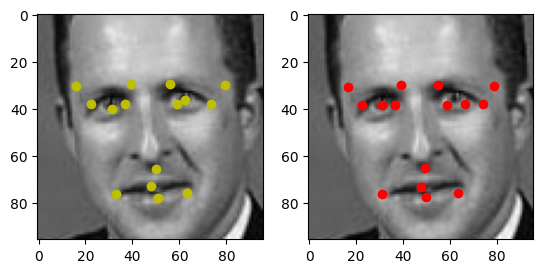

In [42]:
def plot_output(img_number):
  predicted_points = y_pred_xgb[img_number]
  original_points = y_test[img_number]
  plt.subplot(1,2,1)
  plt.imshow(x_test[img_number], cmap='gray')
  for i in range(0, 30, 2):
    plt.scatter(original_points[i:i+2][0], original_points[i:i+2][1], c='y')   # original
  plt.subplot(1,2,2)
  plt.imshow(x_test[img_number], cmap='gray')
  for i in range(0, 30, 2):    
    plt.scatter(predicted_points[i:i+2][0], predicted_points[i:i+2][1], c='r')   # predicted 
plt.show()
plot_output(555)

**Comparing the 3 Models**

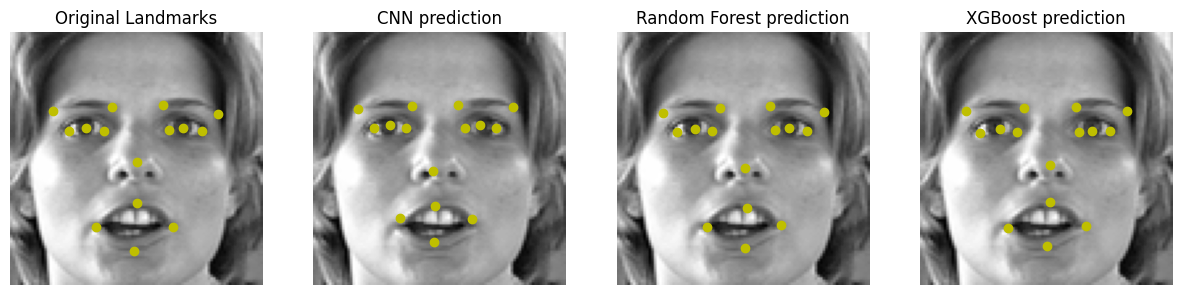

In [56]:
def compare(img_number):    # plotting the comparisons 
  y_pred_cnn = y_pred[img_number]
  y_pred_rf = output_points[img_number]
  y_pred_Xgb = y_pred_xgb[img_number]
  y_original = y_test[img_number]

  plt.figure(figsize=(15,10))
  plt.subplot(1, 4, 1)
  plt.imshow(x_test[img_number], cmap='gray')
  plt.title("Original Landmarks")
  plt.axis("off")
  plt.imshow(x_test[img_number], cmap='gray')
  for i in range(0, 30, 2):
    plt.scatter(y_original[i:i+2][0], y_original[i:i+2][1], c='y')
  
  plt.subplot(1, 4, 2)
  plt.imshow(x_test[img_number], cmap='gray')
  plt.title("CNN prediction")
  plt.axis("off")
  for i in range(0, 30, 2):
    plt.scatter(y_pred_cnn[i:i+2][0], y_pred_cnn[i:i+2][1], c='y')
  
  plt.subplot(1, 4, 3)
  plt.imshow(x_test[img_number], cmap='gray')
  plt.title("Random Forest prediction")
  plt.axis("off")
  for i in range(0, 30, 2):
    plt.scatter(y_pred_rf[i:i+2][0], y_pred_rf[i:i+2][1], c='y')

  plt.subplot(1, 4, 4)
  plt.imshow(x_test[img_number], cmap='gray')
  plt.title("XGBoost prediction")
  plt.axis("off")
  for i in range(0, 30, 2):
    plt.scatter(y_pred_Xgb[i:i+2][0], y_pred_Xgb[i:i+2][1], c='y')
  plt.show()

compare(23)
